# Basic tour through turbESN
This should be understood as a first simple introduction to the turbESN package. 

**Covers**: closed loop prediction w. ESN

**Data**: Lorenz '63 system.

#### References:

- <i>Lorenz, E. N., Deterministic Nonperiodic Flow. J. Atmos. Sci.</i>, Vol. **20**, 130-141, 1963 https://doi.org/10.1175/1520-0469%281963%29020%3C0130%3ADNF%3E2.0.CO%3B2
- <i>Lukoševičius, M., A Practical Guide to Applying Echo State Networks. </i> In: Montavon, G., Orr, G.B., Müller, KR. (eds) Neural Networks: Tricks of the Trade. Lecture Notes in Computer Science, vol **7700** (2012). Springer, Berlin, Heidelberg. Referenceshttps://doi.org/10.1007/978-3-642-35289-8_36

In [17]:
import torch  
import numpy as np

import turbESN
from turbESN.core import ESN
from turbESN.util import minmax_scaling, undo_minmax_scaling, PreparePredictorData, run_turbESN

### 1. Import Lorenz '63 data
- the L63 system has three degrees of freedom: X, Y, Z
- the generated data consists out of $9\cdot 10^4$ timesteps, with time stepping $dt=2\cdot 10^{-3}$

Text(0.5, 0, 'time step')

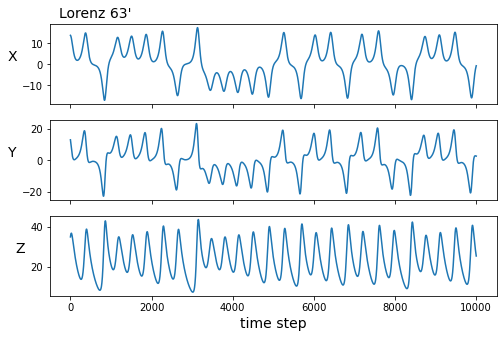

In [3]:
import h5py                      

with h5py.File('lorenz63.hdf5','r') as f:
    data = np.array(f['data'])
    dt = f.attrs['dt']
    
data_timesteps, n_input_data= data.shape

# Visualize data
ylabels = ['X','Y','Z']
fig,axs = plt.subplots(figsize = (8,5), nrows = 3, sharex = True)
for ii in range(n_input_data):
    axs[ii].plot(data[:10000,ii])  
    axs[ii].set_ylabel(ylabels[ii], fontsize = 14, rotation = 0, labelpad = 10)
    
axs[0].set_title("Lorenz 63'", x = .1, fontsize = 14)
axs[-1].set_xlabel('time step',fontsize = 14)

### 2. Prepare data for the ESN
Let's prepare the imported temporal data for input of the ESN:
- define no. time steps in training/testing/validation phase
- scale data to values in [-1,1]

In [9]:
# Data parameters
transientTime = 50          # initial transient that will be discarded from training (used for reservoir initialization)
trainingLength = 4050       # length of training phase
testingLength = 2000        # length of testing phase
validationLength = 2000     # length of validation phase
esn_start = 1               # time step of data at which training phase should start
esn_end = esn_start + trainingLength + testingLength + validationLength    # time step of data at which validation phase should stop

# Min-Max normalization. Note: normalization over training phase only.
x_min = np.min(data[:trainingLength],axis=0)
x_max = np.max(data[:trainingLength],axis=0)
data_scaled = minmax_scaling(data,x_min=x_min,x_max=x_max,dataScaling=1)

# Create training/testing/validation data using PreparePredictorData method
u_train, y_train, u_test, y_test, u_val, y_val = PreparePredictorData(data=data_scaled, 
                                                                      n_input=n_input_data, 
                                                                      trainingLength=trainingLength, 
                                                                      testingLength=testingLength, 
                                                                      validationLength=validationLength,
                                                                      esn_start=esn_start,
                                                                      esn_end=esn_end)

### 3. Initialize ESN :
Create ESN object: all information on ESN hyperparameters is stored here. By default the ESN will be used in closed loop mode (autonomous prediction, where the last prediction is used as basis for a next prediction step)

Here:
- Reservoir size: $N_r = 256$,
- spectral radius: $\varrho=1.1$
- reservoir density: $D=0.2$
- leaking rate: $\gamma = 0.1$
- regression parameter: $\lambda=5\cdot 10^{-1}$
- RNG seed for the random initialization of $W^r, W^{\rm in}, W^{\rm fb}:$ $s = 42$

In [23]:
# Hyperparameters
randomSeed = 41 
n_reservoir = 256
leakingRate = 0.1
spectralRadius =  1.1
reservoirDensity = 0.2
regressionParameter = 5e-1

#ESN
esn = ESN(randomSeed=randomSeed,
          mode='auto',
          esn_start=esn_start,
          esn_end=esn_end,
          trainingLength=trainingLength,
          testingLength=testingLength,
          validationLength=validationLength,
          data_timesteps=data_timesteps,
          n_input=n_input_data,
          n_output=n_input_data,
          n_reservoir=n_reservoir,
          leakingRate=leakingRate,
          spectralRadius=spectralRadius,
          reservoirDensity=reservoirDensity,
          regressionParameter=regressionParameter)

### 4. Run ESN 
run_turbESN:
- simple method that takes the **ESN object**, **training/validation/testing data** as input
- it returns 
    - **predictions** of testing & validation phase
    - losses of the three phases (by default: mean square error (**MSE**) will be used)

In [24]:
loss_dict, y_pred_test, y_pred_val = run_turbESN(esn=esn, 
                                                 u_train=u_train, 
                                                 y_train=y_train, 
                                                 y_test=y_test, 
                                                 u_test=u_test, 
                                                 u_val=u_val,
                                                 y_val=y_val)

print("MSE (train) = {0:.2e}\n".format(loss_dict['mse_train'].mean()) + "MSE (test) = {0:.2e}\n".format(loss_dict['mse_test'].mean()) + "MSE (val) = {0:.2e}\n".format(loss_dict['mse_val'].mean()))

MSE (train) = 9.64e-06
MSE (test) = 1.94e-01
MSE (val) = 3.15e-01



### 5. Evaluate Result

Lets compare the time trajectories of prediction and ground truth during the testing phase.

Text(0.5, 0, 'time step')

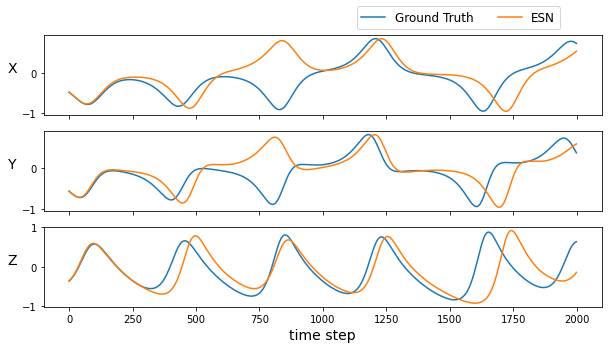

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

ylabels = ['X','Y','Z']
clrs = sns.color_palette()
fig,axs = plt.subplots(figsize = (10,5), nrows = 3, sharex = True)
for ii in range(n_input_data):
    axs[ii].plot(range(testingLength),y_test[:,ii], label = 'Ground Truth',color = clrs[0])
    axs[ii].plot(range(testingLength),y_pred_test[:,ii], label = 'ESN',color=clrs[1])
    axs[ii].set_ylabel(ylabels[ii], fontsize = 14, rotation = 0, labelpad = 10)
    
axs[0].legend(fontsize = 12, ncol = 3, loc = 'lower left', bbox_to_anchor = (.55,1))
axs[-1].set_xlabel('time step',fontsize = 14)

We can also reconstruct the chaotic attractor given by the Z-X plane. Before, we should reverse the normalization procedure done in 2.

Text(0, 0.5, 'Z')

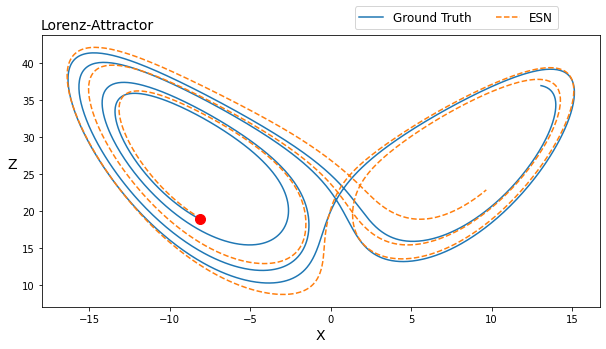

In [18]:
y_test_denom = undo_minmax_scaling(y_test,x_min=x_min,x_max=x_max)
y_pred_test_denom = undo_minmax_scaling(y_pred_test,x_min=x_min,x_max=x_max)


fig,axs = plt.subplots(figsize = (10,5))
axs.plot(y_test_denom[:,0],y_test_denom[:,2],label = 'Ground Truth')
axs.plot(y_pred_test_denom[:,0],y_pred_test_denom[:,2],label = 'ESN', linestyle = 'dashed')

# tidy up
#----------
axs.plot(y_test_denom[0,0],y_test_denom[0,2],color="red",marker=".",markersize=20)
axs.legend(fontsize = 12, ncol = 2, loc = 'lower left', bbox_to_anchor = (.55,1))
axs.set_title("Lorenz-Attractor", x = .1, fontsize = 14)
axs.set_xlabel("X", fontsize = 14, rotation = 0)
axs.set_ylabel("Z", fontsize = 14, rotation = 0, labelpad = 10)

## Explore further:
- change the hyperparameters, e.g. spectral radius and leaking rate. Can you produce a lower MSE during testing?
- change the ESN mode from closed loop (mode='auto') to open loop (mode='teacher'), how does the ESN perform compared to the closed loop scenario? How does this mode differ from closed loop?
- move on to the advanced tour (to come)